## Predicting Subjective Features from Questions on QA Websites using BERT

### Abstract

Modern Question-Answering websites, such as StackOverflow and Quora, have specific user rules to maintain their content quality. These systems rely on user reports for accessing new content, which has serious problems including the slow handling of violations, the loss of normal and experienced users' time, the low quality of some reports, and discouraging feedback to new users. Therefore, with the overall goal of providing solutions for automating moderation actions in Q&A websites, we aim to provide a model to predict 20 quality or subjective aspects of questions in QA websites. To this end, we used data gathered by the CrowdSource team at Google Research in 2019 and a fine-tuned pre-trained BERT model on our problem. Based on the evaluation by Mean-Squared-Error (MSE), the model achieved a value of 0.046 after 2 epochs of training, which did not improve substantially in the next ones. Results confirm that by simple fine-tuning, we can achieve accurate models in little time, and on less amount of data.

Full article: https://arxiv.org/abs/2002.10107

In [2]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.166
cpu cores	: 1
# RAM
MemTotal:       16393696 kB
# GPU

# OS
Linux a6efe813c942 5.10.107+ #1 SMP Sun Apr 24 15:04:08 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux


In [3]:
!pip install ../input/sacremoses > /dev/null

import sys
sys.path.insert(0, "../input/transformers/")

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


2.3.0


#### 1. Read data and tokenizer

Read tokenizer and data, as well as defining the maximum sequence length that will be used for the input to Bert (maximum is usually 512 tokens)

In [5]:
PATH = '../input/google-quest-challenge/'

HAS_ANS = False

# BERT_PATH = '../input/bert-base-from-tfhub/bert_en_uncased_L-12_H-768_A-12'
# tokenizer = tokenization.FullTokenizer(BERT_PATH+'/assets/vocab.txt', True)

BERT_PATH = '../input/bert-base-uncased-huggingface-transformer/'
tokenizer = BertTokenizer.from_pretrained(BERT_PATH+'bert-base-uncased-vocab.txt')

MAX_SEQUENCE_LENGTH = 512

df_train = pd.read_csv(PATH+'train.csv')
df_test = pd.read_csv(PATH+'test.csv')
df_sub = pd.read_csv(PATH+'sample_submission.csv')
print('train shape =', df_train.shape)
print('test shape =', df_test.shape)

del df_train['question_body_critical']

if HAS_ANS:
    output_categories = list(df_train.columns[11:])
    input_categories = list(df_train.columns[[1,2,5]])
else:
    # ISSA
    output_categories = list(df_train.columns[11:31])
    input_categories = list(df_train.columns[[1,2,5]])

TARGET_COUNT = len(output_categories)

print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)
print('\noutput categories:\n\t', output_categories)
print('\ninput categories:\n\t', input_categories)

train shape = (6079, 41)
test shape = (476, 11)

output TARGET_COUNT:
	 20

output categories:
	 ['question_asker_intent_understanding', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']

input categories:
	 ['question_title', 'question_body', 'answer']


In [6]:
print(list(df_train.columns))

['qa_id', 'question_title', 'question_body', 'question_user_name', 'question_user_page', 'answer', 'answer_user_name', 'answer_user_page', 'url', 'category', 'host', 'question_asker_intent_understanding', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [7]:
# import pandas_profiling as pp
# pp.ProfileReport(df_train)

## Distribution

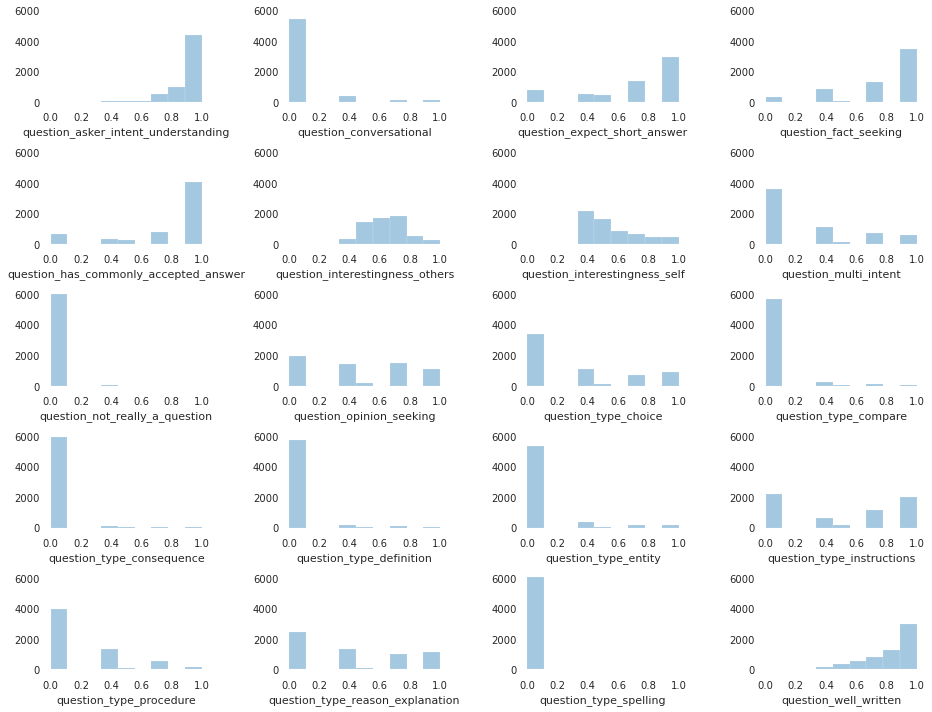

In [7]:

fig, axes = plt.subplots(5, 4, figsize=(13, 10))
axes = axes.ravel()
bins = np.linspace(0, 1, 10)

for i, col in enumerate(output_categories):
    ax = axes[i]
    sns.distplot(df_train[col], label=col, kde=False, bins=bins, ax=ax)
    # ax.set_title(col)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])
plt.tight_layout()
plt.show()
plt.close()

## feature engineering

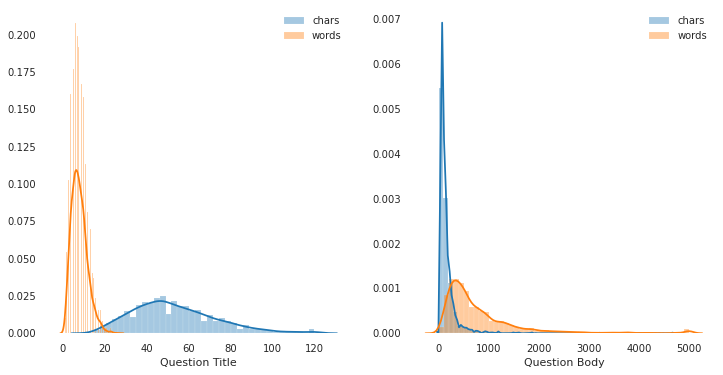

In [9]:
train = df_train.copy()
def char_count(s):
    return len(s)

def word_count(s):
    return s.count(' ')

train['question_title_n_chars'] = train['question_title'].apply(char_count)
train['question_title_n_words'] = train['question_title'].apply(word_count)
train['question_body_n_chars'] = train['question_body'].apply(char_count)
train['question_body_n_words'] = train['question_body'].apply(word_count)

train['question_body_n_chars'].clip(0, 5000, inplace=True)
train['question_body_n_words'].clip(0, 5000, inplace=True)
train['question_title_n_chars'].clip(0, 120, inplace=True)
train['question_title_n_words'].clip(0, 120, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(train['question_title_n_chars'], label='chars', ax=axes[0])
sns.distplot(train['question_title_n_words'], label='words', ax=axes[0])
axes[0].set_xlabel('Question Title')
axes[0].legend()
sns.distplot(train['question_body_n_words'], label='chars', ax=axes[1])
sns.distplot(train['question_body_n_chars'], label='words', ax=axes[1])
axes[1].set_xlabel('Question Body')
axes[1].legend()

In [10]:
train["question_body_n_punctuations"] = train["question_body"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
train["question_body_n_duplicates"] = train["question_body"].apply(lambda x: len(str(x).split()) - len(set(str(x).split())) )
train["question_body_rate_duplicates"] = train["question_body"].apply(lambda x: (len(str(x).split()) - len(set(str(x).split()))) / (len(str(x).split())+1) )
train["question_body_n_sentences"] = train["question_body"].apply(lambda x: len(re.findall("\n",str(x)))+1)

In [11]:
from textblob import TextBlob
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

train['q_body_polarity'] = train['question_body'].apply(pol)
train['q_body_subjectivity'] = train['question_body'].apply(sub)

train[['question_body', 'category', 'q_body_polarity', 'q_body_subjectivity']].head()

,question_body,category,q_body_polarity,q_body_subjectivity
0,After playing around with macro photography on...,LIFE_ARTS,0.165892,0.447527
1,I am trying to understand what kinds of places...,CULTURE,0.157937,0.449206
2,I'm working on a PCB that has through-hole com...,SCIENCE,0.075000,0.554861
3,"An affidavit, from what i understand, is basic...",CULTURE,0.125000,0.303571
4,I am trying to make a binary image. I want mor...,LIFE_ARTS,0.023810,0.352381


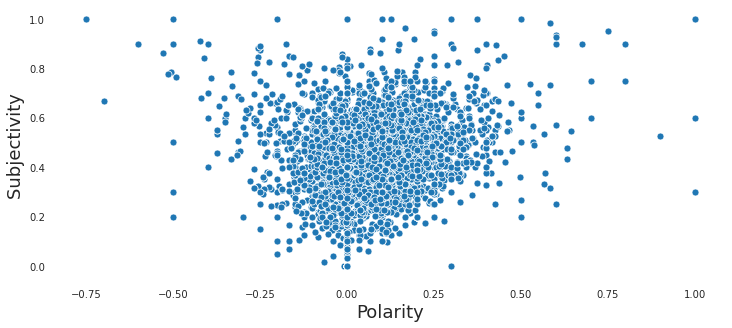

In [12]:
#Polarity and subjectivity plot
plt.figure(figsize=(12,5))
g = sns.scatterplot(x='q_body_polarity', y='q_body_subjectivity', 
                    data=train)
#g.set_title("Sentiment Analysis (Polarity x Subjectivity) of question_body by 'Category' Feature", fontsize=16)
g.set_xlabel("Polarity",fontsize=18)
g.set_ylabel("Subjectivity ",fontsize=18)
plt.show()

## correlation

In [16]:
from scipy.spatial.distance import cdist

def calc_corr(df, x_cols, y_cols):
    arr1 = df[x_cols].T.values
    arr2 = df[y_cols].T.values
    corr_df = pd.DataFrame(1 - cdist(arr2, arr1, metric='correlation'), index=y_cols, columns=x_cols)
    return corr_df

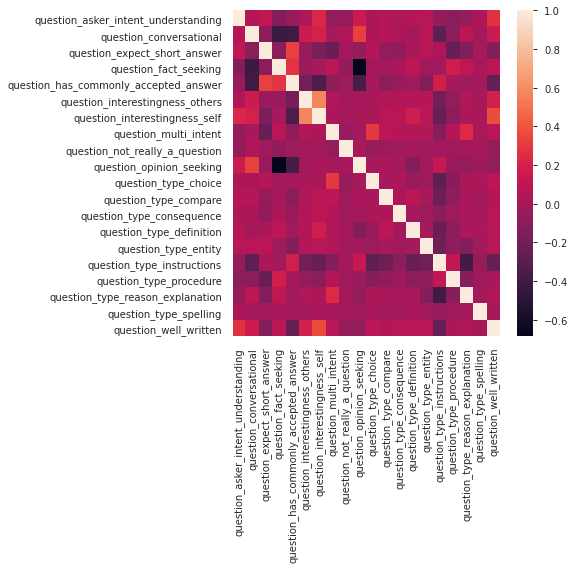

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(df_train[output_categories].corr(), ax=ax)

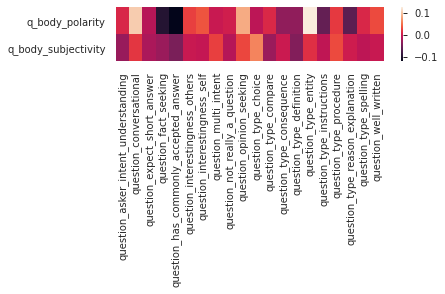

In [17]:
number_feature_cols = ['q_body_polarity', 'q_body_subjectivity']
# train[number_feature_cols].corrwith(train[target_cols], axis=0)

corr_df = calc_corr(train, output_categories, number_feature_cols)
fig, ax = plt.subplots(figsize=(6, 1))
sns.heatmap(corr_df, ax=ax)

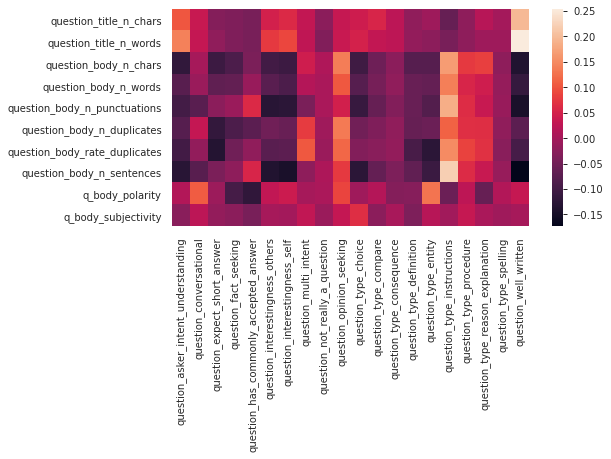

In [32]:


number_feature_cols = ['question_title_n_chars', 'question_title_n_words', 'question_body_n_chars', 'question_body_n_words',
                      'question_body_n_punctuations', 'question_body_n_duplicates', 'question_body_rate_duplicates', 'question_body_n_sentences',
                      'q_body_polarity', 'q_body_subjectivity']
# train[number_feature_cols].corrwith(train[target_cols], axis=0)

corr_df = calc_corr(train, output_categories, number_feature_cols)
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(corr_df, ax=ax)

### 2. Preprocessing functions

These are some functions that will be used to preprocess the raw text data into useable Bert inputs.<br>

*update 4:* credits to [Minh](https://www.kaggle.com/dathudeptrai) for this implementation. If I'm not mistaken, it could be used directly with other Huggingface transformers too! Note that due to the 2 x 512 input, it will require significantly more memory when finetuning BERT.

In [8]:
def _convert_to_transformer_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    input_ids_q, input_masks_q, input_segments_q = return_id(
        title + ' ' + question, None, 'longest_first', max_sequence_length)
    
    input_ids_a, input_masks_a, input_segments_a = return_id(
        answer, None, 'longest_first', max_sequence_length)
        
    return [input_ids_q, input_masks_q, input_segments_q,
            input_ids_a, input_masks_a, input_segments_a]

def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    input_ids_q, input_masks_q, input_segments_q = [], [], []
    input_ids_a, input_masks_a, input_segments_a = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        if HAS_ANS:
            t, q, a = instance.question_title, instance.question_body, instance.answer
        else:
            t, q, a = instance.question_title, instance.question_body, instance.question_title

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = \
        _convert_to_transformer_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_q.append(ids_q)
        input_masks_q.append(masks_q)
        input_segments_q.append(segments_q)
        input_ids_a.append(ids_a)
        input_masks_a.append(masks_a)
        input_segments_a.append(segments_a)
        
    return [np.asarray(input_ids_q, dtype=np.int32), 
            np.asarray(input_masks_q, dtype=np.int32), 
            np.asarray(input_segments_q, dtype=np.int32),
            np.asarray(input_ids_a, dtype=np.int32), 
            np.asarray(input_masks_a, dtype=np.int32), 
            np.asarray(input_segments_a, dtype=np.int32)]

def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [9]:
outputs = compute_output_arrays(df_train, output_categories)
inputs = compute_input_arrays(df_train, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)


## 3. Create model

~~`compute_spearmanr()`~~ `mean_squared_error` is used to compute the competition metric for the validation set
<br><br>
`create_model()` contains the actual architecture that will be used to finetune BERT to our dataset.


In [10]:
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

def create_model():
    q_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig() # print(config) to see settings
    config.output_hidden_states = False # Set to True to obtain hidden states
    # caution: when using e.g. XLNet, XLNetConfig() will automatically use xlnet-large config
    
    # normally ".from_pretrained('bert-base-uncased')", but because of no internet, the 
    # pretrained model has been downloaded manually and uploaded to kaggle. 
    bert_model = TFBertModel.from_pretrained(
        BERT_PATH+'bert-base-uncased-tf_model.h5', config=config)
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    q_embedding = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
    a_embedding = bert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    
    q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    
    x = tf.keras.layers.Concatenate()([q, a])
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(TARGET_COUNT, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[q_id, q_mask, q_atn, a_id, a_mask, a_atn,], outputs=x)
    
    return model

In [11]:
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
_______________________________________________________________________________________

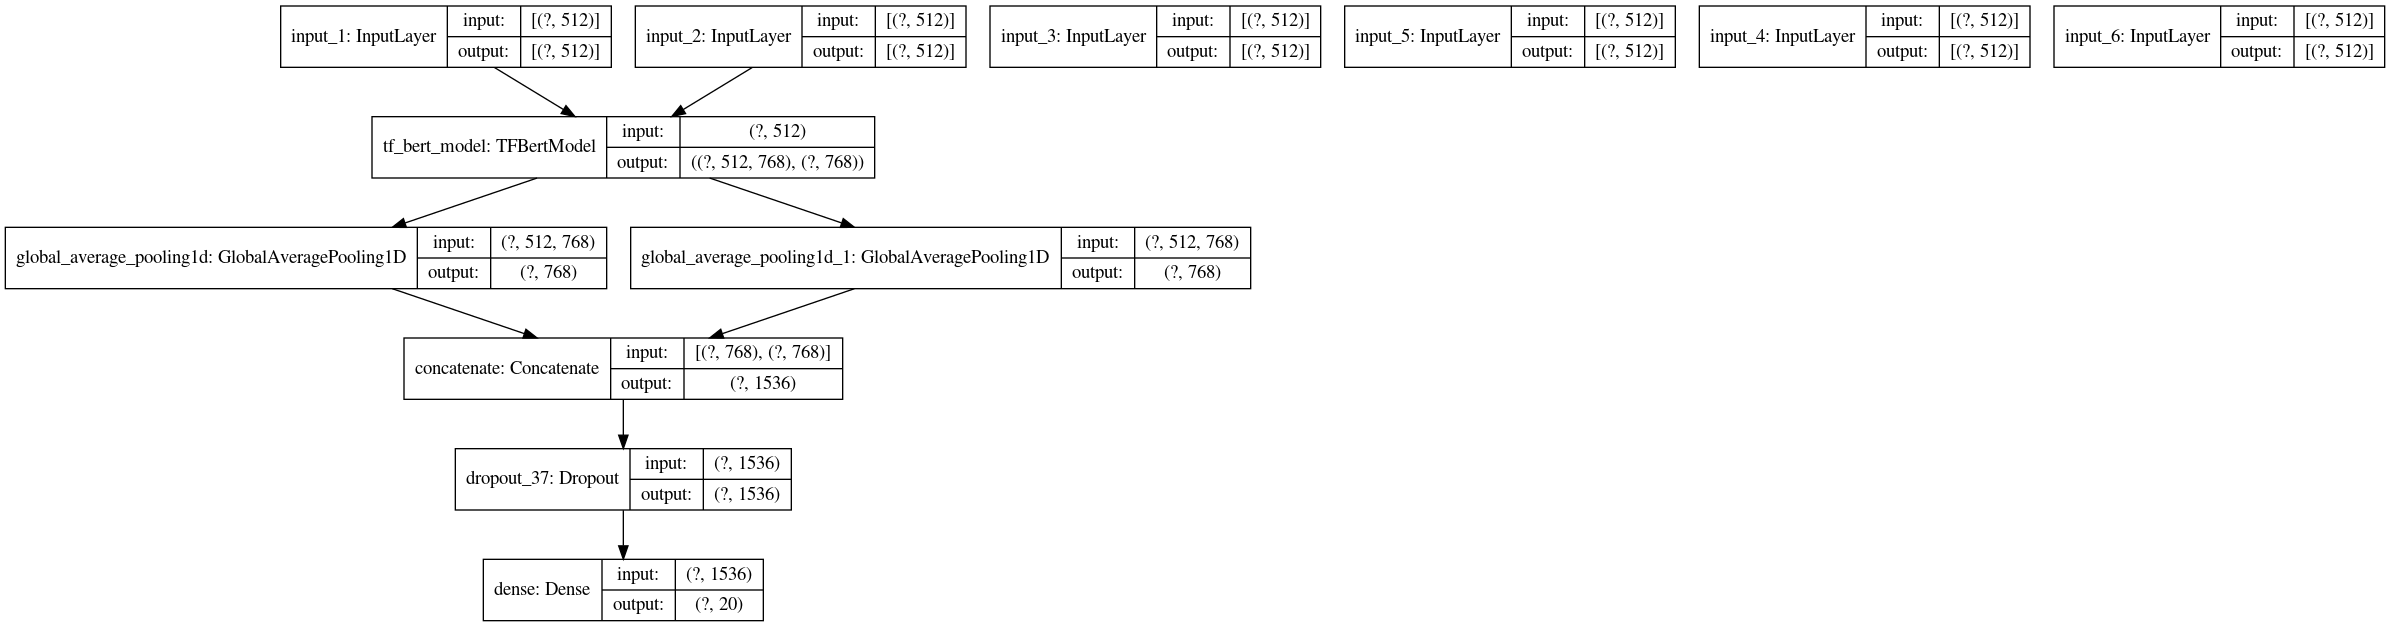

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### 4. Obtain inputs and targets, as well as the indices of the train/validation splits

In [ ]:
output_categories

## 5. Training, validation and testing

Loops over the folds in gkf and trains each fold for 3 epochs --- with a learning rate of 3e-5 and batch_size of 6. A simple binary crossentropy is used as the objective-/loss-function. 

In [ ]:
# Evaluation Metrics
from sklearn.metrics import confusion_matrix
def print_evaluation_metrics(y_true, y_pred, label):
    ### For regression
    print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
    print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
    print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
#     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
    ### FOR Classification
#     print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
#     print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
#     print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#     print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#     print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#     confusion_matrix(y_true, y_pred).ravel()

print_evaluation_metrics([1,0], [0.9,0.1], 'on #'+str(1))

### Loss function selection
Regression problem between 0 and 1, so binary_crossentropy and mean_absolute_error seem good.

Here are the explanations: https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

In [ ]:
training_sample_count = 4700 # 4860
training_epochs = 5 # 3
running_folds = 1 # 2


In [ ]:
for LR in np.arange(1e-5, 10e-5, 2e-5).tolist():
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('LR=', LR)
    gkf = GroupKFold(n_splits=5).split(X=df_train.question_body, groups=df_train.question_body)
    valid_preds = []
    test_preds = []
    for fold, (train_idx, valid_idx) in enumerate(gkf):
        if fold not in range(running_folds):
            continue
        train_inputs = [(inputs[i][train_idx])[:training_sample_count] for i in range(len(inputs))]
        train_outputs = (outputs[train_idx])[:training_sample_count]

        print(np.array(train_inputs).shape, np.array(train_outputs).shape)

        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]

        K.clear_session()
        model = create_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        for xx in range(training_epochs):
            model.fit(train_inputs, train_outputs, epochs=1, batch_size=6)
            # model.save_weights(f'bert-{fold}.h5')
            valid_preds.append(model.predict(valid_inputs))
            test_preds.append(model.predict(test_inputs))
            #rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
            #print('validation score = ', rho_val)
            print_evaluation_metrics(np.array(valid_outputs), np.array(valid_preds[-1]), 'on #'+str(xx+1))

In [ ]:
len(valid_inputs[0])

In [ ]:
print(valid_outputs.shape, valid_preds[-1].shape)
print_evaluation_metrics(np.array(valid_outputs), np.array(valid_preds[-1]), '')